# The Decision Tree on the Churn Dataset

In [1]:
import sys
import pandas as pd
from sklearn import preprocessing
from sklearn.tree import export_text, DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score 
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, FunctionTransformer
from sklearn.model_selection import train_test_split

from IPython.display import display, HTML

sys.path.append("..")

## Select the churn file 

In [2]:
inputFile = "../data/churn.csv"
df = pd.read_csv(inputFile, delimiter=";")
display(df)
print (df.info())

,COLLEGE,INCOME,OVERAGE,LEFTOVER,HOUSE,HANDSET_PRICE,OVER_15MINS_CALLS_PER_MONTH,AVERAGE_CALL_DURATION,REPORTED_SATISFACTION,REPORTED_USAGE_LEVEL,CONSIDERING_CHANGE_OF_PLAN,LEAVE
0,zero,31953,0,6,313378,161,0,4,unsat,little,no,STAY
1,one,36147,0,13,800586,244,0,6,unsat,little,considering,STAY
2,one,27273,230,0,305049,201,16,15,unsat,very_little,perhaps,STAY
3,zero,120070,38,33,788235,780,3,2,unsat,very_high,considering,LEAVE
4,one,29215,208,85,224784,241,21,1,very_unsat,little,never_thought,STAY
...,...,...,...,...,...,...,...,...,...,...,...,...
19995,zero,153252,0,23,368403,597,1,6,very_sat,little,actively_looking_into_it,STAY
19996,one,107126,71,82,237397,609,5,2,very_sat,very_little,no,STAY
19997,zero,78529,0,66,172589,275,0,2,unsat,very_high,considering,LEAVE
19998,zero,78674,47,41,572406,288,4,2,very_unsat,little,considering,LEAVE


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   COLLEGE                      20000 non-null  object
 1   INCOME                       20000 non-null  int64 
 2   OVERAGE                      20000 non-null  int64 
 3   LEFTOVER                     20000 non-null  int64 
 4   HOUSE                        20000 non-null  int64 
 5   HANDSET_PRICE                20000 non-null  int64 
 6   OVER_15MINS_CALLS_PER_MONTH  20000 non-null  int64 
 7   AVERAGE_CALL_DURATION        20000 non-null  int64 
 8   REPORTED_SATISFACTION        20000 non-null  object
 9   REPORTED_USAGE_LEVEL         20000 non-null  object
 10  CONSIDERING_CHANGE_OF_PLAN   20000 non-null  object
 11  LEAVE                        20000 non-null  object
dtypes: int64(7), object(5)
memory usage: 1.8+ MB
None


## Data Preparation
### Transform labels into index

In [3]:
df_features = df.drop("LEAVE",axis=1) # drop label attribute from the features
df_labels = df[["LEAVE"]].copy()
display(df_features)
display(df_labels)

num_attributes = df.select_dtypes(include=["int64"]).columns.tolist()
cat_attributes = df.select_dtypes(exclude=["int64"]).columns.tolist()
cat_attributes.remove("LEAVE")
print(num_attributes)
print(cat_attributes)
cat_encoder = OrdinalEncoder()
label_encoder = OrdinalEncoder()
transform_pipeline = ColumnTransformer([("num",StandardScaler(),num_attributes), \
                                        ("cat",cat_encoder,cat_attributes)]).set_output(transform="pandas")
df_features_prepared = transform_pipeline.fit_transform(df_features)
display(df_features_prepared)
labels_prepared = label_encoder.fit_transform(df_labels)
df_labels_prepared = pd.DataFrame(labels_prepared,columns=["label"],index=df_labels.index)
display(df_labels_prepared)

,COLLEGE,INCOME,OVERAGE,LEFTOVER,HOUSE,HANDSET_PRICE,OVER_15MINS_CALLS_PER_MONTH,AVERAGE_CALL_DURATION,REPORTED_SATISFACTION,REPORTED_USAGE_LEVEL,CONSIDERING_CHANGE_OF_PLAN
0,zero,31953,0,6,313378,161,0,4,unsat,little,no
1,one,36147,0,13,800586,244,0,6,unsat,little,considering
2,one,27273,230,0,305049,201,16,15,unsat,very_little,perhaps
3,zero,120070,38,33,788235,780,3,2,unsat,very_high,considering
4,one,29215,208,85,224784,241,21,1,very_unsat,little,never_thought
...,...,...,...,...,...,...,...,...,...,...,...
19995,zero,153252,0,23,368403,597,1,6,very_sat,little,actively_looking_into_it
19996,one,107126,71,82,237397,609,5,2,very_sat,very_little,no
19997,zero,78529,0,66,172589,275,0,2,unsat,very_high,considering
19998,zero,78674,47,41,572406,288,4,2,very_unsat,little,considering


,LEAVE
0,STAY
1,STAY
2,STAY
3,LEAVE
4,STAY
...,...
19995,STAY
19996,STAY
19997,LEAVE
19998,LEAVE


['INCOME', 'OVERAGE', 'LEFTOVER', 'HOUSE', 'HANDSET_PRICE', 'OVER_15MINS_CALLS_PER_MONTH', 'AVERAGE_CALL_DURATION']
['COLLEGE', 'REPORTED_SATISFACTION', 'REPORTED_USAGE_LEVEL', 'CONSIDERING_CHANGE_OF_PLAN']


,num__INCOME,num__OVERAGE,num__LEFTOVER,num__HOUSE,num__HANDSET_PRICE,num__OVER_15MINS_CALLS_PER_MONTH,num__AVERAGE_CALL_DURATION,cat__COLLEGE,cat__REPORTED_SATISFACTION,cat__REPORTED_USAGE_LEVEL,cat__CONSIDERING_CHANGE_OF_PLAN
0,-1.159524,-0.999876,-0.667462,-0.712267,-1.069218,-0.896417,-0.454804,1.0,2.0,2.0,3.0
1,-1.058899,-0.999876,-0.406424,1.218022,-0.681032,-0.896417,-0.000511,0.0,2.0,2.0,1.0
2,-1.271810,1.674848,-0.891209,-0.745266,-0.882140,0.896261,2.043806,0.0,2.0,4.0,4.0
3,0.954630,-0.557965,0.339400,1.169088,1.825804,-0.560290,-0.909097,1.0,2.0,3.0,1.0
4,-1.225216,1.419005,2.278543,-1.063271,-0.695063,1.456472,-1.136243,0.0,4.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...
19995,1.750752,-0.999876,-0.033512,-0.494261,0.969925,-0.784375,-0.000511,1.0,3.0,2.0,0.0
19996,0.644070,-0.174201,2.166669,-1.013299,1.026048,-0.336206,-0.909097,0.0,3.0,4.0,3.0
19997,-0.042046,-0.999876,1.570010,-1.270064,-0.536047,-0.896417,-0.909097,1.0,2.0,3.0,1.0
19998,-0.038567,-0.453302,0.637730,0.313987,-0.475247,-0.448248,-0.909097,1.0,4.0,2.0,1.0


,label
0,1.0
1,1.0
2,1.0
3,0.0
4,1.0
...,...
19995,1.0
19996,1.0
19997,0.0
19998,0.0


### Spliting the dataset into train and test set

In [4]:
X_train, X_test, y_train, y_test = train_test_split(df_features_prepared,df_labels_prepared,test_size=0.4,random_state=1234)
display (X_train)
display (X_test) 
display (y_train)
display (y_test)

,num__INCOME,num__OVERAGE,num__LEFTOVER,num__HOUSE,num__HANDSET_PRICE,num__OVER_15MINS_CALLS_PER_MONTH,num__AVERAGE_CALL_DURATION,cat__COLLEGE,cat__REPORTED_SATISFACTION,cat__REPORTED_USAGE_LEVEL,cat__CONSIDERING_CHANGE_OF_PLAN
19210,-1.170513,-0.999876,-0.033512,-0.261030,-1.008417,-0.448248,-0.000511,0.0,4.0,2.0,2.0
652,1.603246,1.570185,1.420845,0.725244,1.886604,-0.448248,-1.136243,1.0,2.0,3.0,1.0
9672,-0.114599,-0.150942,-0.182677,-0.843146,0.029862,-0.448248,-0.000511,1.0,2.0,2.0,1.0
8596,-1.358927,1.442263,-0.369133,1.542010,-0.816663,1.120345,-0.454804,1.0,3.0,2.0,4.0
15958,1.554709,-0.999876,-0.891209,-0.602402,0.904448,-0.896417,0.680928,1.0,0.0,0.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...
8222,1.214494,1.058498,1.532719,-1.249950,1.727588,2.016684,-0.909097,1.0,3.0,2.0,0.0
9449,-0.284851,1.337600,-0.667462,1.251782,-0.063677,0.448091,-0.227657,0.0,0.0,4.0,3.0
8471,-0.615469,-0.441673,-0.667462,-1.140973,-0.189954,-0.448248,-0.000511,0.0,4.0,2.0,0.0
17048,0.919073,-0.999876,0.003779,-1.127074,-0.610878,-0.784375,-0.227657,0.0,4.0,3.0,3.0


,num__INCOME,num__OVERAGE,num__LEFTOVER,num__HOUSE,num__HANDSET_PRICE,num__OVER_15MINS_CALLS_PER_MONTH,num__AVERAGE_CALL_DURATION,cat__COLLEGE,cat__REPORTED_SATISFACTION,cat__REPORTED_USAGE_LEVEL,cat__CONSIDERING_CHANGE_OF_PLAN
18172,1.653006,1.430634,2.427708,-1.218765,-0.699740,2.016684,-0.227657,1.0,2.0,4.0,1.0
16075,-0.343105,1.058498,0.264818,1.494185,-0.451862,0.896261,-0.909097,0.0,1.0,3.0,4.0
15388,1.179297,1.035240,-0.667462,-0.657568,0.642540,2.128727,-0.000511,1.0,3.0,3.0,0.0
13842,-1.366077,1.930691,-0.891209,-0.823910,-1.204849,1.344430,1.816660,1.0,4.0,3.0,2.0
8610,-0.902564,-0.999876,0.376692,0.598815,-0.793278,-0.784375,-1.136243,1.0,3.0,0.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...
570,0.386366,-0.999876,-0.033512,1.014077,-0.087062,-0.784375,-0.454804,0.0,3.0,2.0,1.0
13220,1.763924,-0.999876,-0.145385,1.773692,0.273062,-0.784375,-0.227657,0.0,4.0,2.0,2.0
6258,-1.151175,-0.999876,1.197098,1.710876,-1.013094,-0.784375,-0.909097,0.0,1.0,4.0,2.0
15851,-0.765782,1.221308,-0.331841,1.444023,-0.905525,-0.784375,-0.227657,0.0,0.0,2.0,2.0


,label
19210,1.0
652,0.0
9672,0.0
8596,1.0
15958,0.0
...,...
8222,0.0
9449,1.0
8471,1.0
17048,1.0


,label
18172,0.0
16075,0.0
15388,0.0
13842,1.0
8610,1.0
...,...
570,1.0
13220,1.0
6258,1.0
15851,1.0


## Build the decision tree model

|--- num__HOUSE <= 0.44
|   |--- num__OVERAGE <= 0.26
|   |   |--- num__LEFTOVER <= 0.02
|   |   |   |--- num__LEFTOVER <= -0.80
|   |   |   |   |--- class: 0.0
|   |   |   |--- num__LEFTOVER >  -0.80
|   |   |   |   |--- class: 1.0
|   |   |--- num__LEFTOVER >  0.02
|   |   |   |--- num__INCOME <= 1.61
|   |   |   |   |--- class: 0.0
|   |   |   |--- num__INCOME >  1.61
|   |   |   |   |--- class: 0.0
|   |--- num__OVERAGE >  0.26
|   |   |--- num__OVERAGE <= 1.75
|   |   |   |--- num__INCOME <= 1.82
|   |   |   |   |--- class: 0.0
|   |   |   |--- num__INCOME >  1.82
|   |   |   |   |--- class: 0.0
|   |   |--- num__OVERAGE >  1.75
|   |   |   |--- num__HOUSE <= -0.81
|   |   |   |   |--- class: 0.0
|   |   |   |--- num__HOUSE >  -0.81
|   |   |   |   |--- class: 0.0
|--- num__HOUSE >  0.44
|   |--- num__INCOME <= 0.48
|   |   |--- num__HANDSET_PRICE <= -0.43
|   |   |   |--- num__INCOME <= -0.45
|   |   |   |   |--- class: 1.0
|   |   |   |--- num__INCOME >  -0.45
|   |   |   |   |-

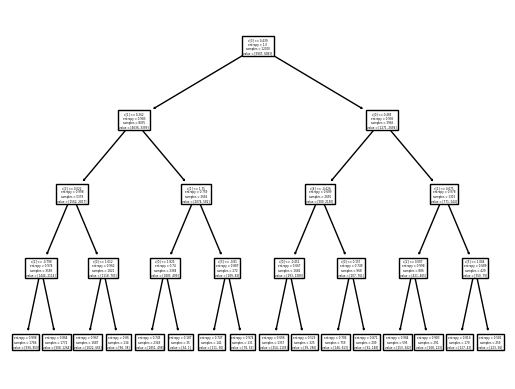

In [5]:
dtc = DecisionTreeClassifier(criterion="entropy", min_samples_leaf=12,max_depth=4)
dtc_model = dtc.fit(X_train,y_train)
plot_tree(dtc_model)
text_tree = export_text(dtc_model, feature_names=X_train.columns.values.tolist())
print(text_tree)

## Do the prediction 

In [6]:
y_pred = dtc_model.predict(X_test)
y_pred
y_prob = dtc_model.predict_proba(X_test)
y_prob

array([[0.78799489, 0.21200511],
       [0.12      , 0.88      ],
       [0.78799489, 0.21200511],
       ...,
       [0.1871776 , 0.8128224 ],
       [0.1871776 , 0.8128224 ],
       [0.86100386, 0.13899614]])

## Manual test

In [7]:
# join the features to the result
result = X_test.copy()
result['prediction'] = y_pred
result = result.join(y_test)
result_orig = result.join(df_features[cat_attributes],rsuffix='_ORIG').join(df_labels)
result_orig["LEAVE_PRED"] = pd.DataFrame(label_encoder.inverse_transform(pd.DataFrame(result_orig['prediction'],index=result_orig.index)),index=result_orig.index)
display(result_orig)

correct = result_orig[result_orig["LEAVE"]==result_orig["LEAVE_PRED"]].shape[0]
incorrect = result_orig[result_orig["LEAVE"]!=result_orig["LEAVE_PRED"]].shape[0]
print("Test Error = " ,(1/(correct+incorrect)) * incorrect )


,num__INCOME,num__OVERAGE,num__LEFTOVER,num__HOUSE,num__HANDSET_PRICE,num__OVER_15MINS_CALLS_PER_MONTH,num__AVERAGE_CALL_DURATION,cat__COLLEGE,cat__REPORTED_SATISFACTION,cat__REPORTED_USAGE_LEVEL,cat__CONSIDERING_CHANGE_OF_PLAN,prediction,label,COLLEGE,REPORTED_SATISFACTION,REPORTED_USAGE_LEVEL,CONSIDERING_CHANGE_OF_PLAN,LEAVE,LEAVE_PRED
18172,1.653006,1.430634,2.427708,-1.218765,-0.699740,2.016684,-0.227657,1.0,2.0,4.0,1.0,0.0,0.0,zero,unsat,very_little,considering,LEAVE,LEAVE
16075,-0.343105,1.058498,0.264818,1.494185,-0.451862,0.896261,-0.909097,0.0,1.0,3.0,4.0,1.0,0.0,one,sat,very_high,perhaps,LEAVE,STAY
15388,1.179297,1.035240,-0.667462,-0.657568,0.642540,2.128727,-0.000511,1.0,3.0,3.0,0.0,0.0,0.0,zero,very_sat,very_high,actively_looking_into_it,LEAVE,LEAVE
13842,-1.366077,1.930691,-0.891209,-0.823910,-1.204849,1.344430,1.816660,1.0,4.0,3.0,2.0,0.0,1.0,zero,very_unsat,very_high,never_thought,STAY,LEAVE
8610,-0.902564,-0.999876,0.376692,0.598815,-0.793278,-0.784375,-1.136243,1.0,3.0,0.0,3.0,1.0,1.0,zero,very_sat,avg,no,STAY,STAY
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
570,0.386366,-0.999876,-0.033512,1.014077,-0.087062,-0.784375,-0.454804,0.0,3.0,2.0,1.0,1.0,1.0,one,very_sat,little,considering,STAY,STAY
13220,1.763924,-0.999876,-0.145385,1.773692,0.273062,-0.784375,-0.227657,0.0,4.0,2.0,2.0,1.0,1.0,one,very_unsat,little,never_thought,STAY,STAY
6258,-1.151175,-0.999876,1.197098,1.710876,-1.013094,-0.784375,-0.909097,0.0,1.0,4.0,2.0,1.0,1.0,one,sat,very_little,never_thought,STAY,STAY
15851,-0.765782,1.221308,-0.331841,1.444023,-0.905525,-0.784375,-0.227657,0.0,0.0,2.0,2.0,1.0,1.0,one,avg,little,never_thought,STAY,STAY


Test Error =  0.293875


## Evaluate / Test the Model 

In [8]:
# Select (prediction, true label) and compute test error.
accuracy = accuracy_score(y_test,y_pred)
print("Test Error = " ,(1.0 - accuracy))

Test Error =  0.293875
